In [1]:
import os
os.chdir('molanalysis')

[['LPE09665', '2023_03_20'], ['LPE10883', '2023_10_23'], ['LPE10883', '2023_10_31'], ['LPE10884', '2023_10_12'], ['LPE10885', '2023_10_20'], ['LPE10919', '2023_11_09'], ['LPE11086', '2023_12_16'], ['LPE11086', '2024_01_09'], ['LPE11495', '2024_02_29'], ['LPE11998', '2024_05_08'], ['LPE12223', '2024_06_11']]


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing pairwise anatomical distance for each session: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
Smoothed interpolation of missing RF:   0%|          | 0/1 [00:00<?, ?it/s]

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'rf_az_F', 'rf_el_F', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id'], dtype='object')


Setting outlier RFs to NaN: 100%|██████████| 1/1 [00:00<?, ?it/s]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\anaconda3\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :

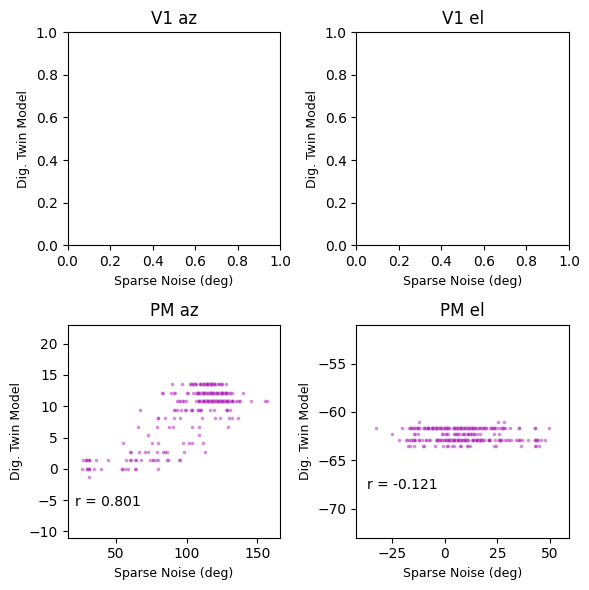

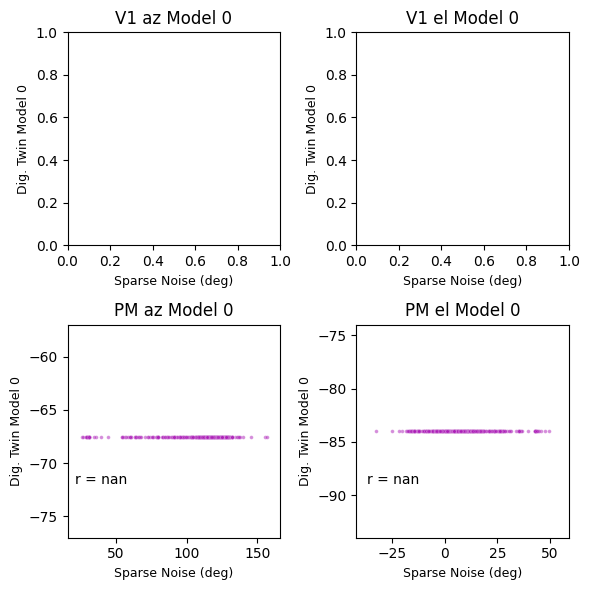

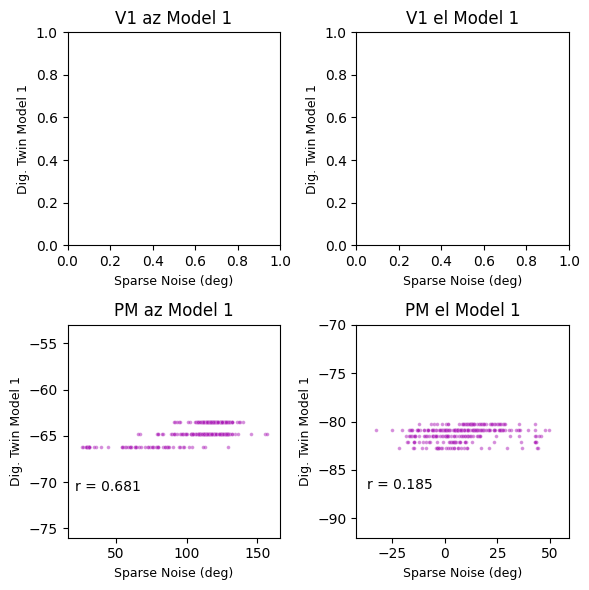

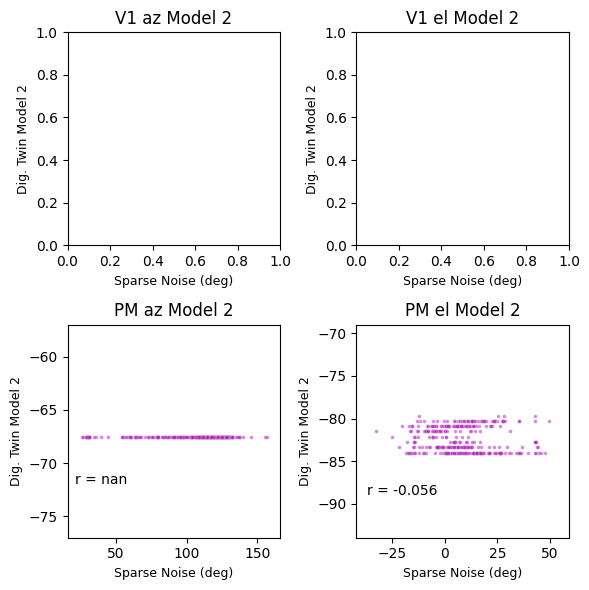

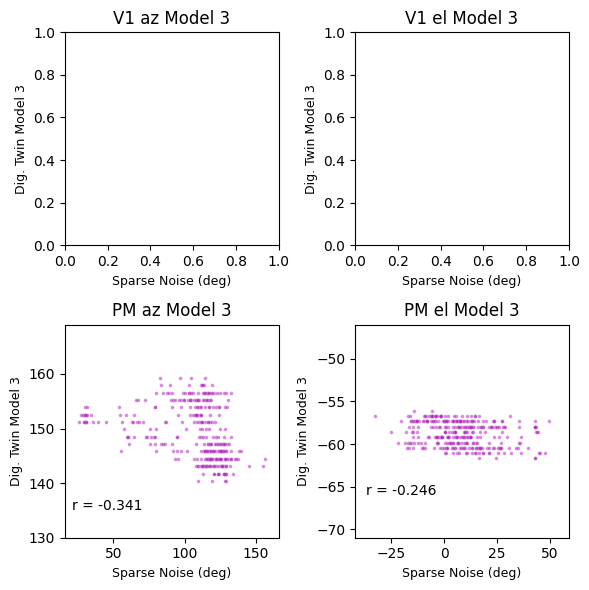

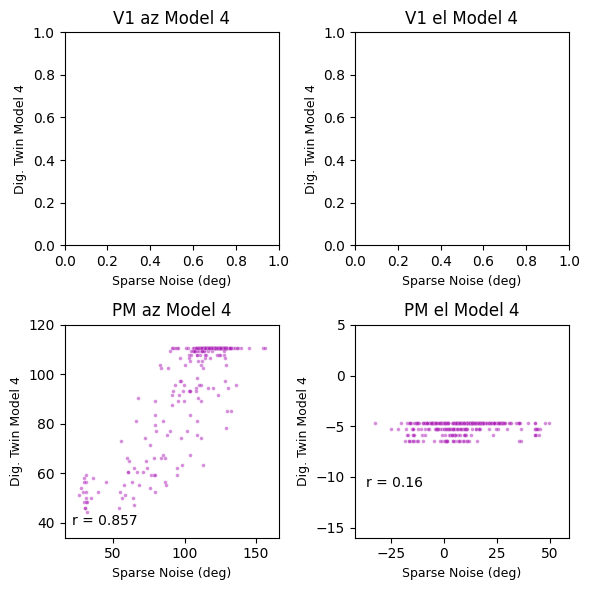

In [2]:
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
""" 

#%% Imports
# Import general libs
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'molanalysis' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('molanalysis')[0] + 'molanalysis'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the molanalysis folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

from naturalimages.sensorium_utility_training_read_config import read_config

run_config = read_config('../Petreanu_MEI_generation/run_config.yaml') # Must be set

RUN_NAME = run_config['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.

keep_behavioral_info = run_config['data']['keep_behavioral_info']
area_of_interest = run_config['data']['area_of_interest']
sessions_to_keep = run_config['data']['sessions_to_keep']
OUTPUT_NAME = run_config['data']['OUTPUT_NAME']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
OUTPUT_FOLDER = f'../molanalysis/MEI_generation/data/{OUTPUT_NAME}' # relative to molanalysis root folder

# os.chdir('../')  # set working directory to the root of the git repo

# Import personal lib funcs
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *

savedir = os.path.join(f'../Petreanu_MEI_generation/runs/{RUN_NAME}/Plots/RF_analysis')
os.makedirs(savedir, exist_ok=True)

# %% Load IM session with receptive field mapping ################################################

# test if folders already defined 
try: 
    folders
except NameError:
    # First level
    folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    folders = [x.replace("\\", "/") for x in folders]
    # Second level
    files = [[folder, os.path.join(folder, name).replace('\\', '/')] for folder in folders for name in os.listdir(
        folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[folder.split("/")[-1], name.split("/")[-1]]
                    for folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]
    print(session_list)

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]


session_list = np.array([['LPE10885', '2023_10_20']])
# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)

#%% 
for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)

#%% Interpolation of receptive fields:
sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

#%% Load the output of digital twin model:
if area_of_interest == 'V1':
    statsfile_V1        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_V1        = pd.read_csv(statsfile_V1)	
elif area_of_interest == 'PM':
    statsfile_PM        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_PM        = pd.read_csv(statsfile_PM)

try:
    statsdata_V1        = pd.read_csv(statsfile_V1)	
except:
    statsdata_V1        = pd.DataFrame(columns=['cell_id', 'mean', 'mean_0', 'mean_1', 'mean_2', 'mean_3', 'mean_4'])

try:
    statsdata_PM        = pd.read_csv(statsfile_PM)
except:
    statsdata_PM        = pd.DataFrame(columns=['cell_id', 'mean', 'mean_0', 'mean_1', 'mean_2', 'mean_3', 'mean_4'])

ises                = 0
statsdata           = pd.concat([statsdata_V1,statsdata_PM]).reset_index(drop=True)

def replace_str(x):
    return x.replace('   ',' ').replace('  ',' ').replace('[ ','').replace(' ]','').replace('[','').replace(']','').split(' ')

mean_columns = ['mean', 'mean_0', 'mean_1', 'mean_2', 'mean_3', 'mean_4']
g = statsdata[mean_columns].applymap(lambda x: replace_str(x))

mergedata = pd.DataFrame(np.array(g['mean'].values.tolist(), dtype=float), columns=['rf_az_Ftwin', 'rf_el_Ftwin',])
for i in range(5):
    temp_df = pd.DataFrame(np.array(g[f'mean_{i}'].values.tolist(), dtype=float), columns=[f'rf_az_Ftwin_{i}', f'rf_el_Ftwin_{i}'])
    mergedata = pd.concat([mergedata, temp_df], axis=1)

mergedata['cell_id'] = statsdata['cell_id']
sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
sessions[ises].celldata['rf_r2_Ftwin'] = 0
sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53
for i in range(5):
    sessions[ises].celldata[f'rf_az_Ftwin_{i}'] = (sessions[ises].celldata[f'rf_az_Ftwin_{i}'] + 0.5) * 135
    sessions[ises].celldata[f'rf_el_Ftwin_{i}'] = (sessions[ises].celldata[f'rf_el_Ftwin_{i}'] + 0.5) * 62 - 53
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 16.7

# #%% Load the output of digital twin model:
# statsfile       = 'E:\\Procdata\\IM\\LPE10885\\2023_10_20\\LPE10885_2023_10_20_neuron_stats.csv'
# statsdata       = pd.read_csv(statsfile)

# g               = statsdata['mean'].apply(lambda x: x.replace('[ ','').replace(' ]','').replace('   ',' ').replace('  ',' ').replace('[','').replace(']','').split(' '))
# g               = np.array(list(g), dtype=float)

# mergedata       = pd.DataFrame(data=g,columns=['rf_az_Ftwin','rf_el_Ftwin'])
# mergedata['cell_id'] = statsdata['cell_id']
# sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
# sessions[ises].celldata['rf_r2_Ftwin'] = 0
# sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53

#%% Make a ascatter of azimuth estimated through rf mapping and by linear model of average triggered image:
areas       = ['V1', 'PM']
spat_dims   = ['az', 'el']
clrs_areas  = get_clr_areas(areas)
# sig_thr     = 0.001
# sig_thr     = 0.05
# sig_thr     = 0.001
r2_thr      = 0.5
rf_type      = 'F'
# rf_type      = 'Fneu'
rf_type_twin = 'Ftwin'
fig,axes     = plt.subplots(2,2,figsize=(6,6))
for iarea,area in enumerate(areas):
    for ispat_dim,spat_dim in enumerate(spat_dims):
        idx         = (sessions[0].celldata['roi_name'] == area) & (sessions[0].celldata['rf_r2_' + rf_type] < r2_thr)
        x = sessions[0].celldata[f'rf_{spat_dim}_{rf_type}'][idx]
        y = sessions[0].celldata[f'rf_{spat_dim}_{rf_type_twin}'][idx]

        sns.scatterplot(ax=axes[iarea,ispat_dim],x=x,y=y,s=7,c=clrs_areas[iarea],alpha=0.5)
        axes[iarea,ispat_dim].set_title(f'{area} {spat_dim}',fontsize=12)
        axes[iarea,ispat_dim].set_xlabel('Sparse Noise (deg)',fontsize=9)
        axes[iarea,ispat_dim].set_ylabel(f'Dig. Twin Model',fontsize=9)
        # if spat_dim == 'az':
        #     axes[iarea,ispat_dim].set_xlim([-50,135])
        #     axes[iarea,ispat_dim].set_ylim([-50,135])
        #     # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        # elif spat_dim == 'el':
        #     axes[iarea,ispat_dim].set_xlim([-150.2,150.2])
        #     axes[iarea,ispat_dim].set_ylim([-150.2,150.2])
            # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        idx = (~np.isnan(x)) & (~np.isnan(y))
        x =  x[idx]
        y =  y[idx]
        # print(f'x min: {min(x) if len(x) > 0 else "None"}')
        # print(f'x max: {max(x) if len(x) > 0 else "None"}')
        # print(f'y min: {min(y) if len(y) > 0 else "None"}')
        # print(f'y max: {max(y) if len(y) > 0 else "None"}')
        if len(x) > 0:
            axes[iarea,ispat_dim].set_xlim([int(min(x) - 10), int(max(x) + 10)])
        if len(y) > 0:
            axes[iarea,ispat_dim].set_ylim([int(min(y) - 10), int(max(y) + 10)])
        # axes[iarea,ispat_dim].text(x=0,y=0.1,s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
        if len(x) > 0 and len(y) > 0:
            axes[iarea,ispat_dim].text(x=int(min(x) - 5),y=int(min(y) - 5),s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
plt.tight_layout()
fig.savefig(os.path.join(savedir, f'Alignment_TwinGaussMean_RF_{rf_type}_{sessions[0].sessiondata["session_id"][0]}.png'), format='png')

for i in range(5):
    fig,axes     = plt.subplots(2,2,figsize=(6,6))
    for iarea,area in enumerate(areas):
        for ispat_dim,spat_dim in enumerate(spat_dims):
            idx         = (sessions[0].celldata['roi_name'] == area) & (sessions[0].celldata['rf_r2_' + rf_type] < r2_thr)
            x = sessions[0].celldata[f'rf_{spat_dim}_{rf_type}'][idx]
            y = sessions[0].celldata[f'rf_{spat_dim}_{rf_type_twin}_{i}'][idx]

            sns.scatterplot(ax=axes[iarea,ispat_dim],x=x,y=y,s=7,c=clrs_areas[iarea],alpha=0.5)
            axes[iarea,ispat_dim].set_title(f'{area} {spat_dim} Model {i}',fontsize=12)
            axes[iarea,ispat_dim].set_xlabel('Sparse Noise (deg)',fontsize=9)
            axes[iarea,ispat_dim].set_ylabel(f'Dig. Twin Model {i}',fontsize=9)
            # if spat_dim == 'az':
            #     axes[iarea,ispat_dim].set_xlim([-50,135])
            #     axes[iarea,ispat_dim].set_ylim([-50,135])
            #     # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
            # elif spat_dim == 'el':
            #     axes[iarea,ispat_dim].set_xlim([-150.2,150.2])
            #     axes[iarea,ispat_dim].set_ylim([-150.2,150.2])
            #     # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
            idx = (~np.isnan(x)) & (~np.isnan(y))
            x =  x[idx]
            y =  y[idx]
            # print(f'x min: {min(x) if len(x) > 0 else "None"}')
            # print(f'x max: {max(x) if len(x) > 0 else "None"}')
            # print(f'y min: {min(y) if len(y) > 0 else "None"}')
            # print(f'y max: {max(y) if len(y) > 0 else "None"}')
            if len(x) > 0:
                axes[iarea,ispat_dim].set_xlim([int(min(x) - 10), int(max(x) + 10)])
            if len(y) > 0:
                axes[iarea,ispat_dim].set_ylim([int(min(y) - 10), int(max(y) + 10)])
            # axes[iarea,ispat_dim].text(x=0,y=0.1,s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
            if len(x) > 0 and len(y) > 0:
                axes[iarea,ispat_dim].text(x=int(min(x) - 5),y=int(min(y) - 5),s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
    plt.tight_layout()
    fig.savefig(os.path.join(savedir, f'Alignment_TwinGaussMean_RF_{rf_type}_{sessions[0].sessiondata["session_id"][0]}_model_{i}.png'), format='png')

#%% ##################### Retinotopic mapping within V1 and PM #####################

# from utils.rf_lib import plot_rf_plane,plot_rf_screen

# oldp = sessions[ises].celldata['rf_r2_F']

# g = -np.log10(sessions[ises].celldata['rf_r2_F'])
# g = 10**-sessions[ises].celldata['rf_r2_F']
# g = 1.01**-sessions[ises].celldata['rf_r2_F']
# plt.hist(g,bins=np.arange(0,0.1,0.001))

# sessions[ises].celldata['rf_r2_F'] = 1.015**-oldp


idx of az, 0        True
1        True
2       False
3        True
4        True
        ...  
1168     True
1169     True
1170     True
1171    False
1172     True
Length: 1173, dtype: bool


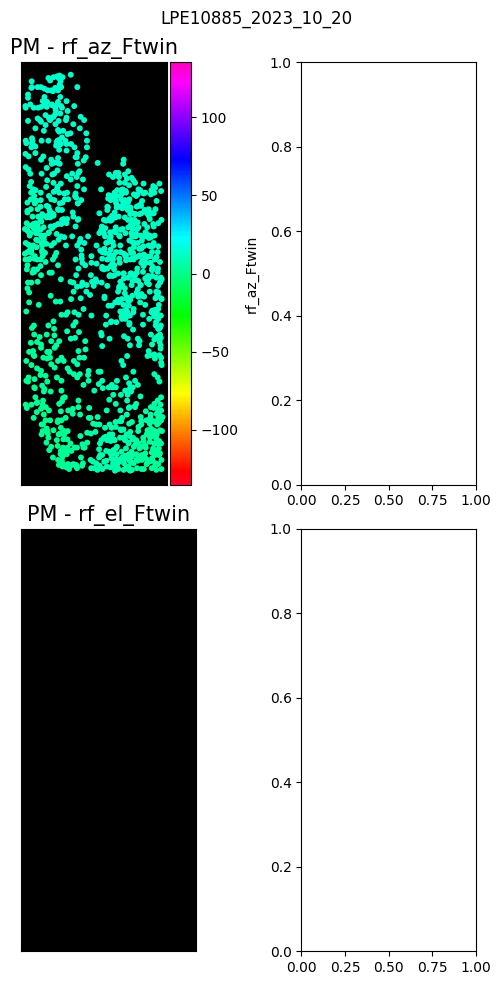

In [5]:

sig_thr = 0
r2_thr  = 0
# rf_type = 'Fsmooth'
rf_type = 'Ftwin'
# for ises in range(nSessions):
ises = 0
celldata = sessions[ises].celldata
areas           = np.sort(celldata['roi_name'].unique())[::-1]
# vars            = ['rf_azimuth','rf_elevation']
vars            = ['rf_az_' + rf_type, 'rf_el_' + rf_type]

# fig,axes        = plt.subplots(2,len(areas),figsize=(5*len(areas),10))
fig,axes        = plt.subplots(2,max(2, len(areas)),figsize=(5*len(areas),10)) # For V1 and PM even if not both areas are present
if 'rf_az_' + rf_type in celldata:
    for i in range(len(vars)): #for azimuth and elevation
        for j in range(len(areas)): #for areas
            
            idx_area    = celldata['roi_name']==areas[j]
            # idx_sig     = celldata['rf_r2_' + rf_type] > r2_thr
            idx_sig     = celldata[vars[i]] > r2_thr
            idx         = np.logical_and(idx_area,idx_sig)
            if np.any(celldata[idx][vars[i]]):
                # if vars[i]=='rf_az_' + rf_type:
                if i == 0:
                    print(f'idx of az, {idx}')
                    sns.scatterplot(data = celldata[idx],x='yloc',y='xloc',hue_norm=(-135,135),
                                hue=vars[i],ax=axes[i,j],palette='gist_rainbow',size=9,edgecolor="none")
                # elif vars[i]=='rf_el_' + rf_type:
                elif i == 1:
                    print(f'idx of el, {idx}')
                    sns.scatterplot(data = celldata[idx],x='yloc',y='xloc',hue_norm=(-16.7,50.2),
                                hue=vars[i],ax=axes[i,j],palette='gist_rainbow',size=9,edgecolor="none")

            box = axes[i,j].get_position()
            axes[i,j].set_position([box.x0, box.y0, box.width * 0.9, box.height * 0.9])  # Shrink current axis's height by 10% on the bottom
            axes[i,j].set_xlabel('')
            axes[i,j].set_ylabel('')
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            axes[i,j].set_xlim([0,512])
            axes[i,j].set_ylim([0,512])
            axes[i,j].set_title(areas[j] + ' - ' + vars[i],fontsize=15)
            axes[i,j].set_facecolor("black")
            axes[i,j].invert_yaxis()

            if vars[i]=='rf_az_' + rf_type:
                norm = plt.Normalize(-135,135)
            elif vars[i]=='rf_el_' + rf_type:
                norm = plt.Normalize(-16.7,50.2)
            sm = plt.cm.ScalarMappable(cmap="gist_rainbow", norm=norm)
            sm.set_array([])

            if np.any(celldata[idx][vars[i]]):
                axes[i,j].get_legend().remove()
                # Remove the legend and add a colorbar (optional)
                axes[i,j].figure.colorbar(sm,ax=axes[i,j],pad=0.02,label=vars[i])
    plt.suptitle(celldata['session_id'][0])
    plt.tight_layout()

In [6]:
idx_area    = celldata['roi_name']==areas[j]
# idx_sig     = celldata['rf_r2_' + rf_type] > r2_thr
idx_sig     = celldata[vars[i]] > r2_thr
idx         = np.logical_and(idx_area,idx_sig)

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Length: 1173, dtype: bool

In [7]:
celldata['roi_name']==areas[j]

0       True
1       True
2       True
3       True
4       True
        ... 
1168    True
1169    True
1170    True
1171    True
1172    True
Name: roi_name, Length: 1173, dtype: bool

In [8]:
celldata[vars[i]] > r2_thr

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Name: rf_el_Ftwin, Length: 1173, dtype: bool

In [9]:
celldata[vars[i]]

0      -61.68
1      -62.92
2      -62.92
3      -63.54
4      -61.68
        ...  
1168   -62.92
1169   -61.68
1170   -61.68
1171   -62.92
1172   -63.54
Name: rf_el_Ftwin, Length: 1173, dtype: float64